# Data Evaluation with NoisySignalIntegration.jl

## Example 2

This example is written a bit more compact and includes polynomial baseline correction as a preprocessing step.

In [1]:
# Project activation and imports

import Pkg
Pkg.activate(".")

using DelimitedFiles
using NoisySignalIntegration
using Plots
using Polynomials

# Set plotting backend and defaults
plotlyjs()
theme(:bright; label=nothing);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4230697546399012248\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1833994303105226055\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4230697546399012248\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Import the dataset (you can upload your own dataset and change the name of the loaded file here):

In [2]:
datafilename = "testdata-2.csv"
delimiter = ',' # verify that this is the right delimiter in case you work with your own data

dataset = let
    dat = readdlm(datafilename, delimiter)
    Curve(dat[:,1], dat[:,2])
end

plot(dataset)

Subtract polynomial:

In [3]:
dataset_baselinecorrected = let
    crv = stitch(crop(dataset, 0, 25), crop(dataset, 85, 120), crop(dataset, 135, 300))
    p = Polynomials.fit(crv.x, crv.y, 3)
    scatter(crv; label="baseline points")
    plot!(dataset; label="full dataset")
    plot!(p, 0, 300; label="polynomial baseline", color=:black) |> display
    Curve(dataset.x, dataset.y - p.(dataset.x))
end;

Divide into signal and noise:

In [4]:
signal = crop(dataset_baselinecorrected, 0, 150)
noisesample = NoiseSample(crop(dataset_baselinecorrected, 150, 300))

plot(signal; label="signal")
plot!(noisesample; label="noise")

Analyze noise sample and derive noise model:

In [5]:
noisemodel = fit_noise(noisesample)

plot(noisesample, noisemodel)

Prepare uncertain curve:

In [6]:
unc_signal = add_noise(signal, noisemodel)

plot(unc_signal; legend=:topleft)

Define integration bounds and plot:

┌ Info: Saved animation to 
│   fn = /tmp/jl_2Crozy.gif
└ @ Plots /home/jovyan/.julia/packages/Plots/isZEW/src/animation.jl:104


Plots.AnimatedGif("/tmp/jl_2Crozy.gif")
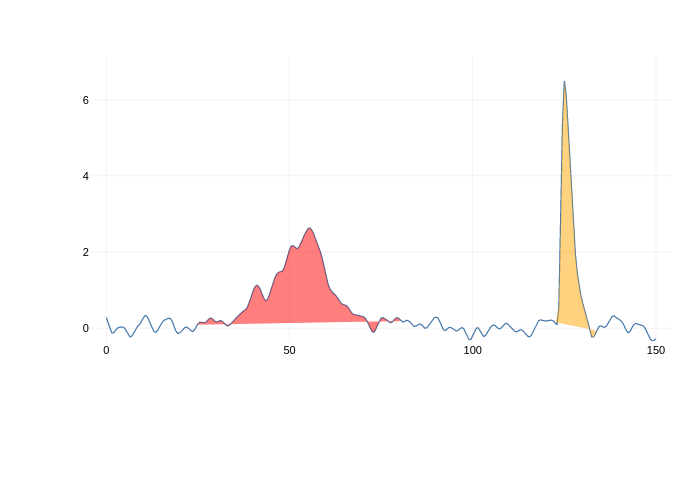

In [7]:
β22(a, b) = scale_shift_beta(2, 2, a, b)
leftbnd  = UncertainBound(β22(20, 30), β22(75, 85))
rightbnd = UncertainBound(β22(120.5, 123.5), β22(130, 135));

NoisySignalIntegration.animate_draws(unc_signal, [leftbnd, rightbnd]; local_baseline=true, size=(100, 50))

Integrate the signals:

In [8]:
L, R = mc_integrate(unc_signal, [leftbnd, rightbnd]; local_baseline=true)

2-element Vector{MonteCarloMeasurements.Particles{Float64, 10000}}:
 39.8 ± 2.9
 21.2 ± 0.71

Calculate further quantities, e.g. a ratio:

In [9]:
L/R

MonteCarloMeasurements.Particles{Float64, 10000}
 1.87424 ± 0.152